In [10]:
from dotenv import find_dotenv, load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
import time
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import numpy as np
from warnings import filterwarnings
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

filterwarnings("ignore")



In [11]:
PROJECT_PATH=os.getenv('PROJECT_PATH')
NUMBER_OF_GAMES_MINIMUM=int(os.getenv('NUMBER_OF_GAMES_MINIMUM'))


In [12]:
def get_samples(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr=list(v[(v.index<offset+num_samples)&(v.index>=offset)]["Elo"])
            samples[p]=arr
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    
    return samples

def get_samples_ts(players_dict,offset,num_samples):
    samples={}
    for p in players_dict:
        try:
            v=players_dict[p]
            arr_Timestamp=(v[(v.index<offset+num_samples)&(v.index>=offset)]["Timestamp"])
            samples[p]=arr_Timestamp
        except Exception as err:
            print(err)
            pass
        
    for p in list(samples.keys()):
        if len(samples[p])!=num_samples:
            del samples[p]

    print(samples)
    return samples

def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)


def kmeans_silhoutte(X_train,metric,max_k=10):
    silhoutte_score = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = silhouette_score(X_train, y_pred, metric=metric)
        silhoutte_score.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),silhoutte_score,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('silhoutte');
    plt.title("Silhouette analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-Silhouette-plot-{metric}-{max_k}.png")

    return silhoutte_score

def kmeans_calinski_harabasz(X_train,metric,max_k=10):
    scores = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        y_pred = model.fit_predict(X_train)
        score = metrics.calinski_harabasz_score(X_train, y_pred)
        scores.append(score)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(range(2,10),scores,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('calinski harabasz');
    plt.title("calinski harabasz For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-calinski-harabasz-plot-{metric}-{max_k}.png")

    return scores



def kmeans_wcsss(X_train,metric,model_name,max_k=10):
    wcss = []
    for i in range(2,max_k+1):
        start = time.time()
        model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
        model.fit_predict(X_train)
        print(model.inertia_)
        wcss.append(model.inertia_)
        stop = time.time()
        duration = stop - start
        print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

    plt.figure(figsize=(20,max_k+1))
    plt.grid()
    plt.plot(range(2,max_k+1),wcss,marker='o',linestyle='--')
    plt.xlabel('number of clusters')
    plt.ylabel('WCSSS');
    plt.title("WCSSS analysis For Optimal K and Optimal Model")
    plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/kmeans-wcsss-plot-{model_name}.png")

    return wcss

def kmeans_cluster(n_clusters,algo,X_train,metric):
    model= TimeSeriesKMeans(n_clusters=n_clusters,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)
    y_pred = model.fit_predict(X_train)
    # model.to_pickle(f"{PROJECT_PATH}/models/fics/{algo}.pkl")



    for yi in range(len(np.unique(y_pred))):
      for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)


      plt.plot(model.cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, X_train.shape[1])
      plt.ylim(-5, 5)
      plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
      plt.title("kmeans")
      plt.tight_layout()
      plt.savefig(f"{PROJECT_PATH}/reports/figures/fics/{algo}-clusters-{(yi + 1)}-{n_clusters}-{metric}.png")
      plt.show();
  

    for i in range(len(np.unique(y_pred))):
      count = (sum(y_pred == i)/len(y_pred))*100
      print(f"The {count:.2f}% of the observations fall into Cluster {i + 1}")

    return y_pred



In [13]:
with open(f"{PROJECT_PATH}/data/fics/interim/players_dict_v2.pkl", 'rb') as f:
    players_dict=pickle.load(f)

In [14]:
df=pd.DataFrame.from_dict(get_samples(players_dict,42,150)).T

In [15]:
df_dt=df.copy()

In [16]:
for i in range(1,len(df_dt.columns)):
    df_dt[i]=df[i]-df[i-1]

df_dt[0]=df[0]-df[0]

In [19]:
df_copy=df.copy()

In [20]:
df=df_dt

In [34]:
from scipy.stats import skew

all_max=[]
all_skew=[]
all_mean=[]
all_var=[]
all_min=[]

for c in df.columns:
    all_max.append(max(df[c]))
    all_min.append(min(df[c]))
    all_skew.append(skew(df[c]))
    all_var.append(np.var(df[c]))
    all_mean.append(sum(df[c])/(len(df[c])))



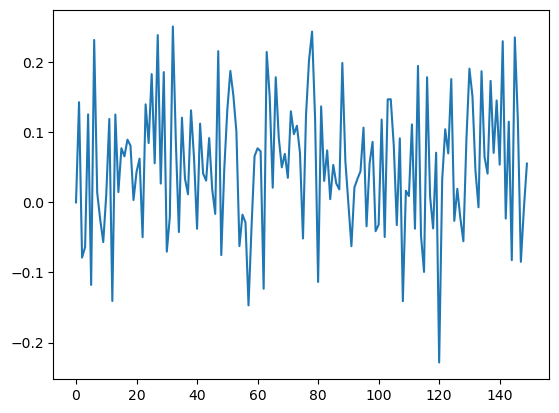

In [30]:

plt.plot(all_mean)

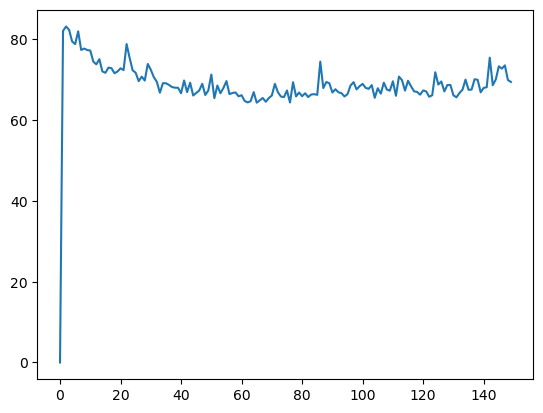

In [32]:

plt.plot(all_var)

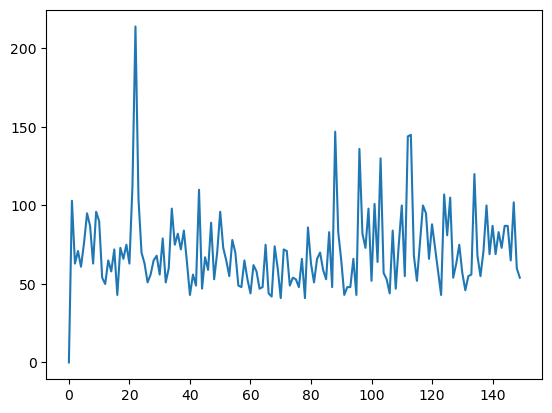

In [27]:

plt.plot(all_max)

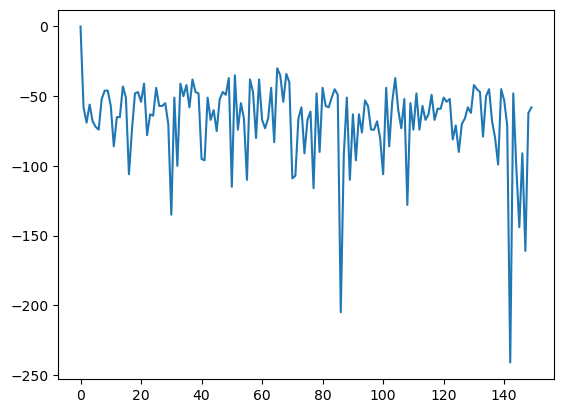

In [35]:

plt.plot(all_min)

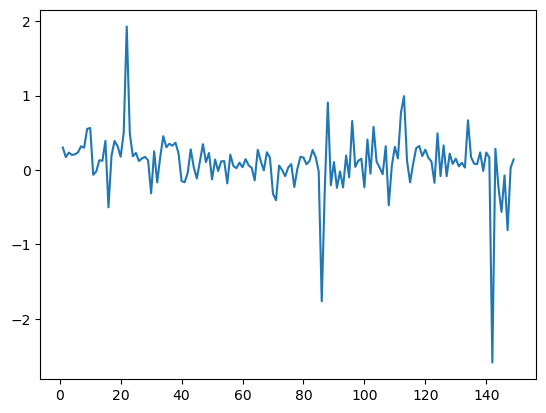

In [28]:
plt.plot(all_skew)


In [49]:
from tsfresh.feature_extraction.feature_calculators import mean_abs_change

player_mean=[]
player_var=[]
player_skew=[]
player_improvment=[]
player_energy=[]
player_mean_abs_change=[]


for p in df.index:
    c=list(df_copy[df.index==p].values)[0]
    player_mean.append(np.mean(c))
    player_var.append(np.var(c))
    player_skew.append(skew(c))
    player_mean_abs_change.append(mean_abs_change(c))
    x=sum(list(df[df.index==p].values)[0])

    if x>0:
        player_improvment.append(1)
    if x==0:
        player_improvment.append(0)
    if x==-1:
        player_improvment.append(-1)

df["Mean"]=player_mean
df["Var"]=player_var
df["Skew"]=player_skew
df["Label"]=player_improvment
df["mean_abs_change"]=player_mean_abs_change

In [53]:
df_copy["Player"]=df_copy.index
df_copy["Id"]=[i for i in range(len(df_copy.index))]


In [54]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,Player,Id
osvifr,1572,1579,1571,1575,1563,1570,1577,1576,1580,1587,...,1645,1653,1643,1649,1640,1642,1645,1651,osvifr,0
Anmelus,1461,1458,1455,1452,1477,1501,1493,1512,1529,1520,...,1531,1539,1547,1555,1546,1556,1548,1540,Anmelus,1
Tohotmos,1499,1493,1503,1493,1481,1471,1478,1484,1481,1495,...,1507,1503,1515,1509,1512,1505,1511,1519,Tohotmos,2
denij,1526,1531,1536,1541,1534,1544,1532,1536,1532,1530,...,1514,1525,1527,1534,1512,1479,1496,1509,denij,3
diegoandrescas,1402,1397,1394,1387,1382,1376,1375,1384,1378,1373,...,1371,1370,1383,1377,1372,1377,1368,1366,diegoandrescas,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,1830,1820,1827,1835,1826,1822,1818,1825,1832,1828,...,1684,1691,1701,1693,1685,1677,1686,1678,PaulVerhoeven,7321
davefromreading,1305,1297,1288,1297,1302,1306,1313,1320,1334,1326,...,1446,1439,1429,1434,1435,1441,1431,1438,davefromreading,7322
schlechterZug,1989,1976,1982,1973,1961,1951,1942,1933,1926,1932,...,1979,1985,1974,1980,1986,1991,1997,1989,schlechterZug,7323
replo,1284,1287,1268,1271,1260,1263,1255,1264,1252,1234,...,1231,1242,1252,1234,1242,1236,1223,1210,replo,7324


In [56]:
from tsfresh import extract_features
extracted_features = extract_features(df_copy, column_id="Player", column_sort="Id")


Feature Extraction:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
extracted_features

In [45]:
!pip install tsfresh

  Using cached tsfresh-0.20.2-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached tsfresh-0.20.2-py2.py3-none-any.whl (95 kB)


In [ ]:
from tsfresh import extract_features
extracted_features = extract_features(df_copy, column_id="id", column_sort="time")



In [47]:
df

,0,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,Mean,Var,Skeq,Label,Skew
osvifr,0,7,-8,4,-12,7,7,-1,4,7,...,6,-9,2,3,6,1587.100000,667.690000,0.558041,1,0.558041
Anmelus,0,-3,-3,-3,25,24,-8,19,17,-9,...,8,-9,10,-8,-8,1520.166667,763.058889,0.130716,1,0.130716
Tohotmos,0,-6,10,-10,-12,-10,7,6,-3,14,...,-6,3,-7,6,8,1526.166667,1073.165556,0.013247,1,0.013247
denij,0,5,5,5,-7,10,-12,4,-4,-2,...,7,-22,-33,17,13,1496.780000,911.531600,0.125609,1,0.125609
diegoandrescas,0,-5,-3,-7,-5,-6,-1,9,-6,-5,...,-6,-5,5,-9,-2,1388.160000,350.854400,0.606350,1,0.606350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,0,-10,7,8,-9,-4,-4,7,7,-4,...,-8,-8,-8,9,-8,1739.600000,1242.720000,0.998149,1,0.998149
davefromreading,0,-8,-9,9,5,4,7,7,14,-8,...,5,1,6,-10,7,1397.360000,1515.043733,-0.811422,1,-0.811422
schlechterZug,0,-13,6,-9,-12,-10,-9,-9,-7,6,...,6,6,5,6,-8,1945.866667,1309.675556,-0.110561,1,-0.110561
replo,0,3,-19,3,-11,3,-8,9,-12,-18,...,-18,8,-6,-13,-13,1249.786667,1126.207822,1.065792,1,1.065792


In [21]:
df_copy

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
osvifr,1572,1579,1571,1575,1563,1570,1577,1576,1580,1587,...,1639,1642,1645,1653,1643,1649,1640,1642,1645,1651
Anmelus,1461,1458,1455,1452,1477,1501,1493,1512,1529,1520,...,1532,1525,1531,1539,1547,1555,1546,1556,1548,1540
Tohotmos,1499,1493,1503,1493,1481,1471,1478,1484,1481,1495,...,1498,1500,1507,1503,1515,1509,1512,1505,1511,1519
denij,1526,1531,1536,1541,1534,1544,1532,1536,1532,1530,...,1557,1534,1514,1525,1527,1534,1512,1479,1496,1509
diegoandrescas,1402,1397,1394,1387,1382,1376,1375,1384,1378,1373,...,1386,1378,1371,1370,1383,1377,1372,1377,1368,1366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,1830,1820,1827,1835,1826,1822,1818,1825,1832,1828,...,1703,1693,1684,1691,1701,1693,1685,1677,1686,1678
davefromreading,1305,1297,1288,1297,1302,1306,1313,1320,1334,1326,...,1452,1454,1446,1439,1429,1434,1435,1441,1431,1438
schlechterZug,1989,1976,1982,1973,1961,1951,1942,1933,1926,1932,...,1996,1987,1979,1985,1974,1980,1986,1991,1997,1989
replo,1284,1287,1268,1271,1260,1263,1255,1264,1252,1234,...,1240,1218,1231,1242,1252,1234,1242,1236,1223,1210


In [14]:

%%time

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values
ss = StandardScaler()

scaled_ss = ss.fit_transform(df.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df.columns, index=df.index)
X_ss = df_ss.values
display(df_ss.head())

# Normalization
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df.columns, index=df.index)
X_mm = df_mm.values
display(df_mm.head())


# convert dataframe to time_series_dataset
X = to_time_series_dataset(df.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)

print(X.shape, X_train.shape)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
osvifr,-0.073857,0.907790,-1.195740,0.487084,-1.756682,0.907790,0.907790,-0.214093,0.487084,0.907790,...,0.627320,0.346849,0.346849,1.048026,-1.476211,0.767555,-1.335976,0.206613,0.346849,0.767555
Anmelus,-0.063077,-0.422375,-0.422375,-0.422375,2.931076,2.811310,-1.021206,2.212479,1.972947,-1.140972,...,0.895052,-0.901440,0.655520,0.895052,0.895052,0.895052,-1.140972,1.134584,-1.021206,-1.021206
Tohotmos,-0.014164,-0.651565,1.048170,-1.076499,-1.288966,-1.076499,0.729470,0.623236,-0.332865,1.473104,...,-0.651565,0.198302,0.729470,-0.439098,1.260637,-0.651565,0.304536,-0.757799,0.623236,0.835703
denij,0.008017,0.361718,0.361718,0.361718,-0.487163,0.715418,-0.840864,0.290977,-0.274943,-0.133463,...,0.432458,-1.619004,-1.406784,0.786158,0.149497,0.503198,-1.548264,-2.326405,1.210598,0.927638
diegoandrescas,0.031993,-0.634522,-0.367916,-0.901127,-0.634522,-0.767824,-0.101310,1.231718,-0.767824,-0.634522,...,0.165296,-1.034430,-0.901127,-0.101310,1.764930,-0.767824,-0.634522,0.698507,-1.167733,-0.234613


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
osvifr,0.608696,0.913043,0.260870,0.782609,0.086957,0.913043,0.913043,0.565217,0.782609,0.913043,...,0.826087,0.739130,0.739130,0.956522,0.173913,0.869565,0.217391,0.695652,0.739130,0.869565
Anmelus,0.285714,0.200000,0.200000,0.200000,1.000000,0.971429,0.057143,0.828571,0.771429,0.028571,...,0.514286,0.085714,0.457143,0.514286,0.514286,0.514286,0.028571,0.571429,0.057143,0.057143
Tohotmos,0.500000,0.350000,0.750000,0.250000,0.200000,0.250000,0.675000,0.650000,0.425000,0.850000,...,0.350000,0.550000,0.675000,0.400000,0.800000,0.350000,0.575000,0.325000,0.650000,0.700000
denij,0.542857,0.614286,0.614286,0.614286,0.442857,0.685714,0.371429,0.600000,0.485714,0.514286,...,0.628571,0.214286,0.257143,0.700000,0.571429,0.642857,0.228571,0.071429,0.785714,0.728571
diegoandrescas,0.464286,0.285714,0.357143,0.214286,0.285714,0.250000,0.428571,0.785714,0.250000,0.285714,...,0.500000,0.178571,0.214286,0.428571,0.928571,0.250000,0.285714,0.642857,0.142857,0.392857


(7326, 150, 1) (7326, 150, 1)
CPU times: user 684 ms, sys: 7.21 ms, total: 691 ms
Wall time: 692 ms


In [18]:
wcss=kmeans_wcsss(X_ss,"euclidean","euclidean_t_150x_k_100",100)

149.10310839727043
K = 2. Took 9.23 seconds to calculate.


KeyboardInterrupt: 

In [19]:
# Experiment number 1. (1/2)
from sklearn.metrics import  calinski_harabasz_score
silhoutte_score_ss = []
X=X_ss
for i in range(2, 100):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X)
  print("1",time.time()-start)
  score_ss = calinski_harabasz_score(X, y_pred_ss)
  print("2",time.time()-start)

  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} {score_ss} seconds to calculate.")

1 4.110084056854248
2 4.115160703659058
K = 2. Took 4.12 41.34957796376816 seconds to calculate.
1 3.9777402877807617
2 3.9819209575653076
K = 3. Took 3.98 35.910338152416024 seconds to calculate.
1 4.0555806159973145
2 4.059670448303223
K = 4. Took 4.06 31.177715549273426 seconds to calculate.
1 4.055839776992798
2 4.0594494342803955
K = 5. Took 4.06 28.392972460710347 seconds to calculate.
1 3.823883056640625
2 3.8274784088134766
K = 6. Took 3.83 26.106819563765434 seconds to calculate.
1 3.804567337036133
2 3.808182954788208
K = 7. Took 3.81 24.384605601799176 seconds to calculate.
1 4.021874666213989
2 4.026186227798462
K = 8. Took 4.03 23.19478078104647 seconds to calculate.
1 4.080274820327759
2 4.0845301151275635
K = 9. Took 4.08 21.780465263914675 seconds to calculate.
1 4.144608497619629
2 4.148809909820557
K = 10. Took 4.15 20.69644313273454 seconds to calculate.
1 3.9058165550231934
2 3.909836530685425
K = 11. Took 3.91 19.79014678061814 seconds to calculate.
1 3.91462707519

Traceback (most recent call last):
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_87221/1395871029.py", line 10, in <module>
    y_pred_ss = km.fit_predict(X)
                ^^^^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/tslearn/clustering/kmeans.py", line 854, in fit_predict
    return self.fit(X, y).labels_
           ^^^^^^^^^^^^^^
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/tslearn/clustering/kmeans.py", line 821, in fit
    self._fit_one_init(X_, x_squared_norms, rs)
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/tslearn/clustering/kmeans.py", line 690, in _fit_one_init
    self._update_centroids(X)
  File "/home/ariel/anaconda3/lib/python3.11/site-packages/tslearn/clustering/kmeans.py", line 762, in _update_centroids
    self.cluster_centers_[k] = euclidean_barycenter(X=X[self.l

In [ ]:
# Experiment number 1.
plt.figure(figsize=(12, 98))
plt.plot(range(1, 99), silhoutte_score_ss, "-o", c="C3")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS"]);
# plt.show()

In [ ]:
best_i=0
for i in range(0,len(silhoutte_score_ss)):
    if max(silhoutte_score_ss)==silhoutte_score_ss[i]:
        best_i=i

best_i

In [ ]:
labels=kmeans_cluster(i, "euclidean",X,"euclidean")

In [67]:
def sign(x):
    if x>0:
        return 1
    if x==0:
        return 0
    return -1

for i in range(1,len(df_dt.columns)-1):
    df_dt2[i]=df[i]-df[i-1]
    df_dt2[i]=df_dt2[i].apply(lambda x:sign(x))

df_dt2[0]=df[0]-df[0]

In [68]:
df_dt

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
osvifr,0.0,0.350000,0.100000,0.366667,0.150000,0.416667,0.100000,-0.166667,0.000000,-0.200000,...,1.133333,1.133333,1.050000,1.316667,1.100000,1.133333,1.150000,1.050000,1.266667,1.416667
Anmelus,0.0,0.716667,1.000000,0.933333,1.250000,0.750000,0.566667,0.583333,0.150000,-0.250000,...,0.566667,0.500000,0.650000,0.550000,0.466667,0.650000,0.516667,0.700000,0.666667,0.583333
Tohotmos,0.0,1.000000,0.983333,0.716667,1.000000,1.266667,1.500000,1.500000,1.383333,1.333333,...,-1.100000,-0.733333,-0.316667,-0.100000,0.383333,-0.050000,-0.300000,-0.633333,-0.766667,-0.600000
denij,0.0,-1.383333,-1.300000,-1.566667,-1.566667,-1.150000,-1.050000,-0.750000,-0.700000,-0.533333,...,0.583333,0.416667,0.466667,0.516667,0.833333,0.900000,0.266667,-0.333333,0.233333,0.250000
diegoandrescas,0.0,-0.283333,-0.316667,-0.166667,-0.133333,0.100000,0.366667,0.216667,0.216667,0.183333,...,0.116667,0.066667,-0.100000,-0.216667,-0.166667,-0.416667,-0.700000,-0.500000,-0.633333,-0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,0.0,-1.333333,-0.916667,-1.150000,-1.316667,-1.050000,-0.866667,-0.950000,-1.216667,-1.466667,...,-0.616667,-0.816667,-0.866667,-0.650000,-0.583333,-0.816667,-1.033333,-1.033333,-0.750000,-0.766667
davefromreading,0.0,1.800000,2.050000,2.316667,2.000000,1.783333,1.666667,1.583333,1.233333,1.133333,...,0.766667,0.683333,0.500000,0.550000,0.416667,0.650000,0.566667,0.516667,0.316667,0.416667
schlechterZug,0.0,-1.250000,-0.900000,-0.883333,-0.750000,-0.450000,-0.450000,-0.183333,-0.050000,0.033333,...,1.350000,1.083333,0.833333,0.833333,0.500000,0.450000,0.400000,0.666667,0.666667,0.433333
replo,0.0,-0.783333,-0.900000,-0.450000,-0.633333,-0.583333,-0.566667,-0.383333,-0.383333,-0.283333,...,0.416667,-0.266667,0.283333,0.183333,0.116667,-0.500000,-0.583333,-0.900000,-1.000000,-1.150000


In [69]:
df_dt

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
osvifr,0.0,0.350000,0.100000,0.366667,0.150000,0.416667,0.100000,-0.166667,0.000000,-0.200000,...,1.133333,1.133333,1.050000,1.316667,1.100000,1.133333,1.150000,1.050000,1.266667,1.416667
Anmelus,0.0,0.716667,1.000000,0.933333,1.250000,0.750000,0.566667,0.583333,0.150000,-0.250000,...,0.566667,0.500000,0.650000,0.550000,0.466667,0.650000,0.516667,0.700000,0.666667,0.583333
Tohotmos,0.0,1.000000,0.983333,0.716667,1.000000,1.266667,1.500000,1.500000,1.383333,1.333333,...,-1.100000,-0.733333,-0.316667,-0.100000,0.383333,-0.050000,-0.300000,-0.633333,-0.766667,-0.600000
denij,0.0,-1.383333,-1.300000,-1.566667,-1.566667,-1.150000,-1.050000,-0.750000,-0.700000,-0.533333,...,0.583333,0.416667,0.466667,0.516667,0.833333,0.900000,0.266667,-0.333333,0.233333,0.250000
diegoandrescas,0.0,-0.283333,-0.316667,-0.166667,-0.133333,0.100000,0.366667,0.216667,0.216667,0.183333,...,0.116667,0.066667,-0.100000,-0.216667,-0.166667,-0.416667,-0.700000,-0.500000,-0.633333,-0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PaulVerhoeven,0.0,-1.333333,-0.916667,-1.150000,-1.316667,-1.050000,-0.866667,-0.950000,-1.216667,-1.466667,...,-0.616667,-0.816667,-0.866667,-0.650000,-0.583333,-0.816667,-1.033333,-1.033333,-0.750000,-0.766667
davefromreading,0.0,1.800000,2.050000,2.316667,2.000000,1.783333,1.666667,1.583333,1.233333,1.133333,...,0.766667,0.683333,0.500000,0.550000,0.416667,0.650000,0.566667,0.516667,0.316667,0.416667
schlechterZug,0.0,-1.250000,-0.900000,-0.883333,-0.750000,-0.450000,-0.450000,-0.183333,-0.050000,0.033333,...,1.350000,1.083333,0.833333,0.833333,0.500000,0.450000,0.400000,0.666667,0.666667,0.433333
replo,0.0,-0.783333,-0.900000,-0.450000,-0.633333,-0.583333,-0.566667,-0.383333,-0.383333,-0.283333,...,0.416667,-0.266667,0.283333,0.183333,0.116667,-0.500000,-0.583333,-0.900000,-1.000000,-1.150000


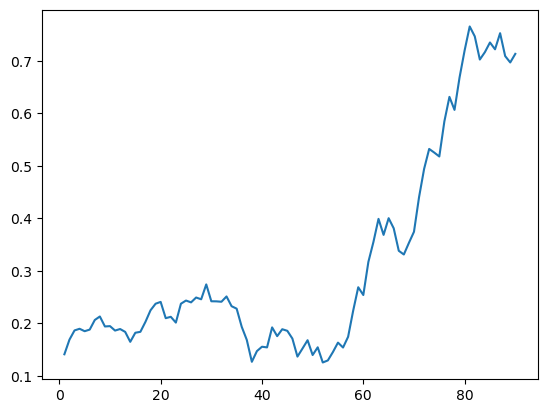

In [71]:
points=[]
for c in df_dt.columns:
    points.append(skew(df_dt[c]))


plt.plot(points)


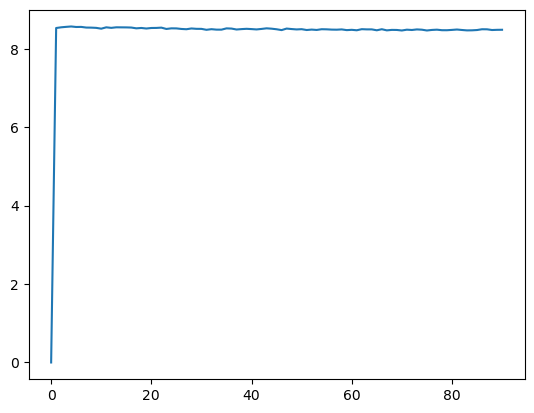

In [73]:

points=[]
for c in df_dt.columns:
    points.append(get_entropy(df_dt[c]))


plt.plot(points)


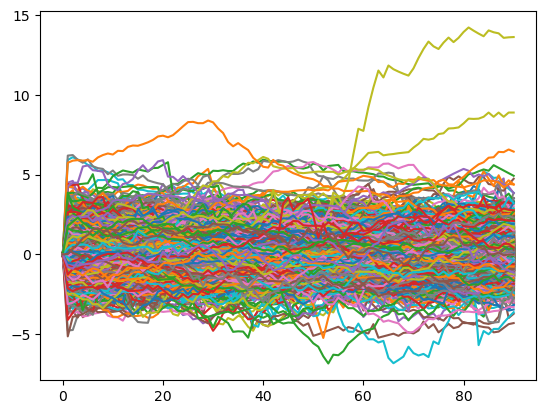

In [74]:
for i in  (df_dt.index):
    plt.plot(list(df_dt[df_dt.index==i].values)[0])


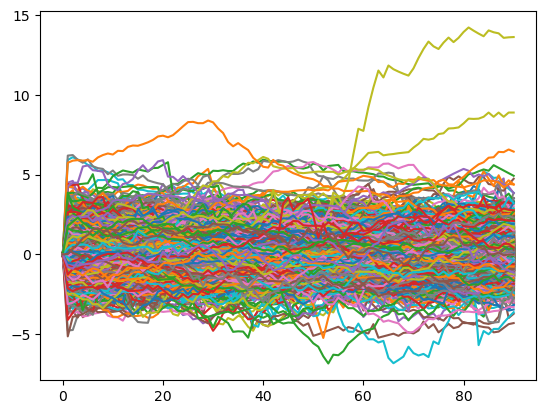

In [75]:
for i in  (df_dt.index):
    plt.plot(list(df_dt[df_dt.index==i].values)[0])


In [76]:
improving=[]
not_improving=[]
getting_worse=[]
amounts=[]
for p in df.index:
    amount=sum((list(df_dt[df_dt.index==p].values))[0])
    amounts.append(amount)
    if amount>0:
        improving.append(p)
    elif amount==0:
        not_improving.append(p)
    else:
        getting_worse.append(p)




In [77]:
len(getting_worse),len(improving),len(not_improving)

(3430, 3896, 0)

In [78]:
min(amounts)

-313.39999999999986

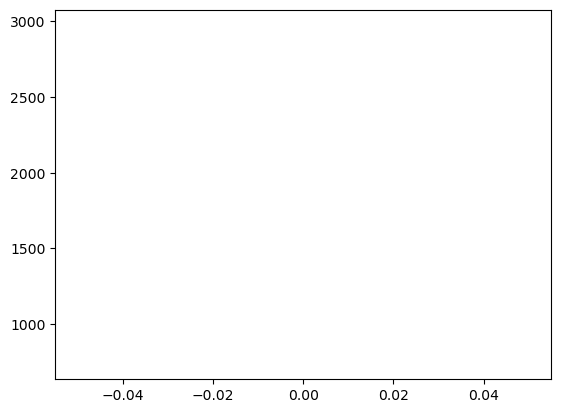

In [79]:
for i in range(len(getting_worse)):
    plt.plot(df[df.index==getting_worse[i]].values)


In [80]:
for i in range(len(not_improving)):
    plt.plot(list(df[df.index==not_improving[i]].values)[0])


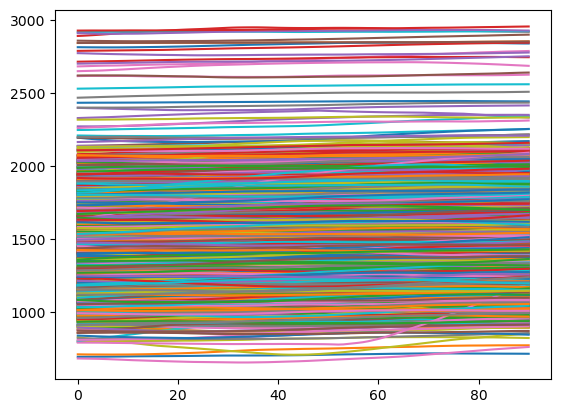

In [81]:
for i in range(len(improving)):
    plt.plot(list(df[df.index==improving[i]].values)[0])


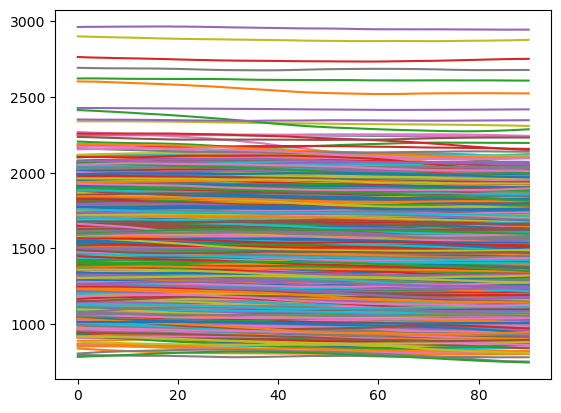

In [82]:
for i in range(len(getting_worse)):
    plt.plot(list(df[df.index==getting_worse[i]].values)[0])


In [83]:
from scipy.stats import entropy
import numpy as np

def get_entropy(data):
    values, counts = np.unique(data, return_counts=True)
    probabilities = counts / counts.sum()

    # Calculate entropy
    entropy_value = entropy(probabilities, base=2)

    return entropy_value

In [84]:
for i in range(len(improving)):
    print(get_entropy(list(df[df.index==improving[i]].values)[0]))


6.419882552286609
6.4638385962426534
6.4418605742646315
6.507794640198697
6.4638385962426534
6.4418605742646315
6.507794640198697
6.4638385962426534
6.4638385962426534
6.419882552286609
6.507794640198697
6.4638385962426534
6.507794640198697
6.4638385962426534
6.4638385962426534
6.419882552286609
6.367631041273824
6.4555431291859104
6.507794640198697
6.507794640198697
6.4418605742646315
6.375926508330565
6.507794640198697
6.507794640198697
6.485816618220675
6.507794640198697
6.507794640198697
6.4638385962426534
6.433565107207889
6.4638385962426534
6.507794640198697
6.485816618220675
6.4638385962426534
6.4638385962426534
6.419882552286609
6.507794640198697
6.485816618220675
6.507794640198697
6.507794640198697
6.331970464374521
6.485816618220675
6.4638385962426534
6.367631041273822
6.4418605742646315
6.507794640198697
6.4418605742646315
6.507794640198697
6.507794640198697
6.419882552286609
6.4638385962426534
6.419882552286609
6.485816618220675
6.419882552286609
6.375926508330565
6.5077946

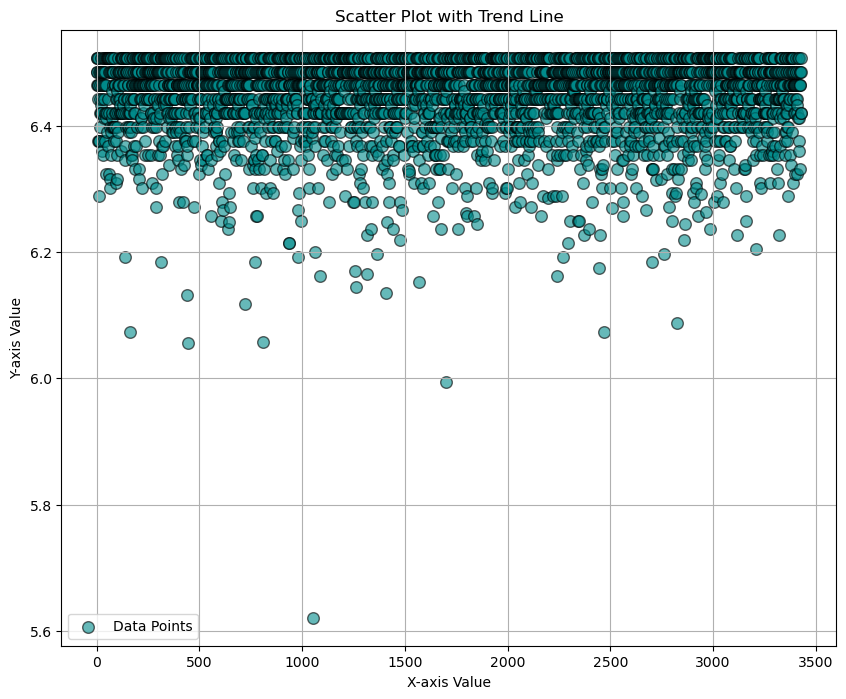

In [85]:
getting_worse_entropy=[]
for i in range(len(getting_worse)):
    getting_worse_entropy.append(get_entropy(list(df[df.index==getting_worse[i]].values)[0]))

# Creating a more detailed scatter plot
plt.figure(figsize=(10, 8))
plt.scatter([i for i in range(len(getting_worse_entropy))], getting_worse_entropy, color='darkcyan', alpha=0.6, edgecolor='black', s=70, label='Data Points')
plt.title('Scatter Plot with Trend Line')
plt.xlabel('X-axis Value')
plt.ylabel('Y-axis Value')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
from scipy.stats import skew

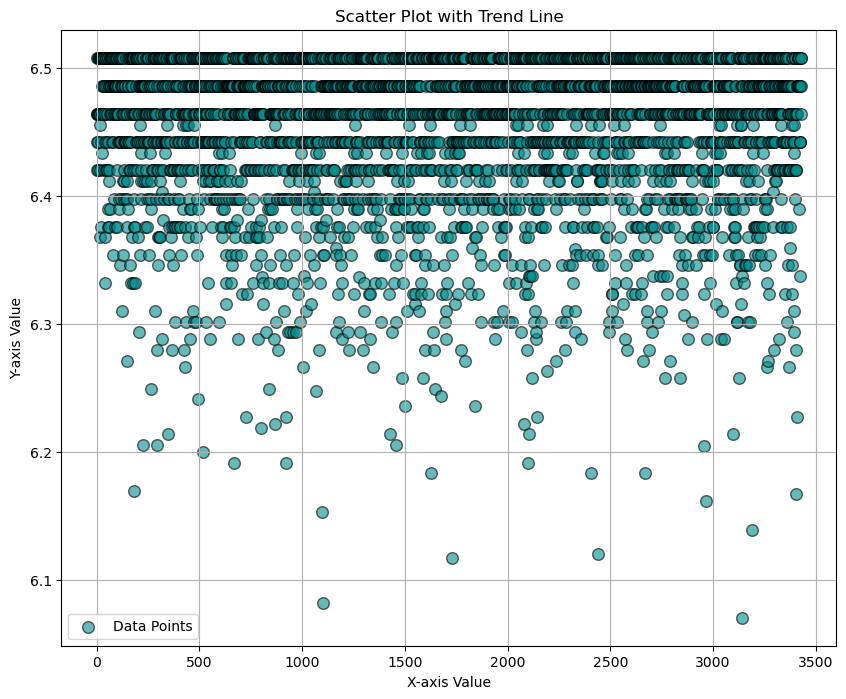

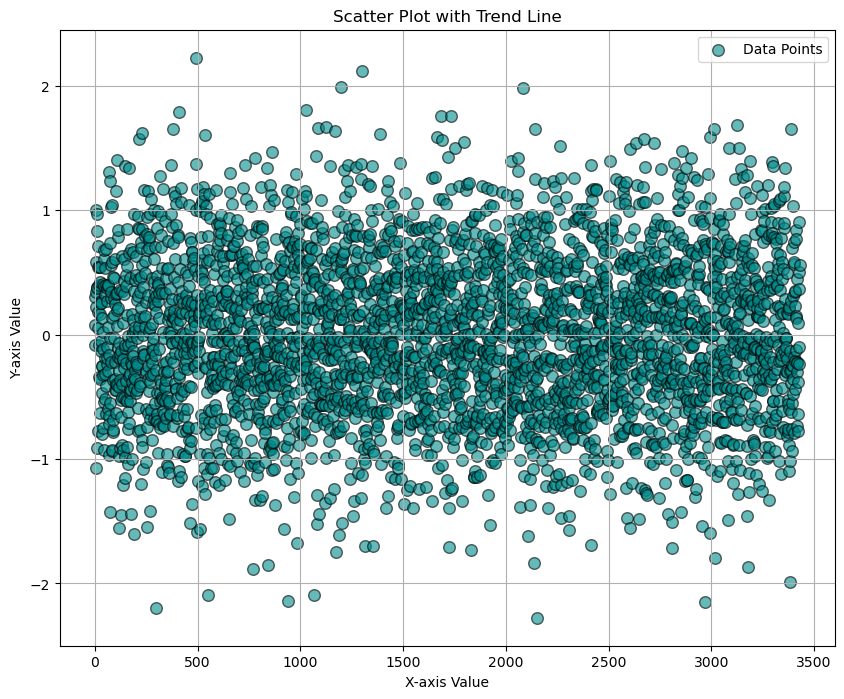

In [87]:
improving_entropy=[]
improving_skew=[]
for i in range(len(getting_worse)):
    improving_entropy.append(get_entropy(list(df[df.index==improving[i]].values)[0]))
    improving_skew.append(skew(list(df[df.index==improving[i]].values)[0]))


# Creating a more detailed scatter plot
plt.figure(figsize=(10, 8))
plt.scatter([i for i in range(len(improving_entropy))], improving_entropy, color='darkcyan', alpha=0.6, edgecolor='black', s=70, label='Data Points')
plt.title('Scatter Plot with Trend Line')
plt.xlabel('X-axis Value')
plt.ylabel('Y-axis Value')
plt.legend()
plt.grid(True)
plt.show()


# Creating a more detailed scatter plot
plt.figure(figsize=(10, 8))
plt.scatter([i for i in range(len(improving_skew))], improving_skew, color='darkcyan', alpha=0.6, edgecolor='black', s=70, label='Data Points')
plt.title('Scatter Plot with Trend Line')
plt.xlabel('X-axis Value')
plt.ylabel('Y-axis Value')
plt.legend()
plt.grid(True)
plt.show()